### MLB HoF classifier test
Simple player HoF classifier, players are categorized into the following classes
- HoF: Are in the hall through voting or through committee
- Very good: Have received 20% on the ballot
- Others

Datasets
```
curl -LJ https://github.com/chadwickbureau/baseballdatabank/raw/master/core/Batting.csv > Batting.csv
curl -LJ https://github.com/chadwickbureau/baseballdatabank/raw/master/core/HallOfFame.csv > HoF.csv
curl -LJ https://github.com/chadwickbureau/baseballdatabank/raw/master/core/People.csv > People.csv
```

In [123]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

In [213]:
# Data parsing
players_dict = {}
hof_dict = {}
id2index = {}
players_stats = []
players_label = []
        
def f(s):
    if s == "":
        return 0.
    return float(s)

with open("./datasets/mlb/HoF.csv") as FH:
    for idx, line in enumerate(FH):
        if idx == 0:
            continue
        tokens = line.split(",")
        player_id = tokens[0]
        ballots = tokens[3]
        votes = tokens[5]
        inducted = tokens[6]
        category = tokens[7]
        
        if player_id in hof_dict or category != "Player":
            continue
                
        # HoF=2, Close=1, Else=0
        if inducted == "Y":
            hof_dict[player_id] = 2
        elif (f(votes) / f(ballots)) > 0.0:
            hof_dict[player_id] = 1

            
with open("./datasets/mlb/People.csv") as FH:
    for idx, line in enumerate(FH):
        if idx == 0:
            continue
        tokens = line.split(",")
        player_id = tokens[0]
        player_name = tokens[13] + " " + tokens[14]
        players_dict[player_id] = player_name

temp_dict = {}
with open("./datasets/mlb/Batting.csv") as FH:
    for idx, line in enumerate(FH):
        if idx == 0:
            continue
        tokens = line.split(",")
        player_id = tokens[0]
        games = f(tokens[5])
        at_bats = f(tokens[6])
        runs = f(tokens[7])
        hits = f(tokens[8])
        homeruns = f(tokens[11])
        rbis = f(tokens[12])
        steals = f(tokens[13])
        walks = f(tokens[15])
        
        pid = player_id
        if player_id in temp_dict:
            temp_dict[pid]["games"] += games
            temp_dict[pid]["at_bats"] += at_bats
            temp_dict[pid]["runs"] += runs
            temp_dict[pid]["hits"] += hits
            temp_dict[pid]["homeruns"] += homeruns
            temp_dict[pid]["rbis"] += rbis
            temp_dict[pid]["steals"] += steals
            temp_dict[pid]["walks"] += walks            
        else:
            temp_dict[pid] = {}
            temp_dict[pid]["games"] = games
            temp_dict[pid]["at_bats"] = at_bats
            temp_dict[pid]["runs"] = runs
            temp_dict[pid]["hits"] = hits
            temp_dict[pid]["homeruns"] = homeruns
            temp_dict[pid]["rbis"] = rbis
            temp_dict[pid]["steals"] = steals
            temp_dict[pid]["walks"] = walks
            
        # if player_id == "ruthba01":
        #    print(temp_dict["ruthba01"])
                        
        # metrics = np.array([games, runs, hits, homeruns, rbis, steals, walks])
        # players_stats.append(metrics)
        # 
        # if player_id in hof_dict:
        #     players_label.append(hof_dict[player_id])
        # else:
        #     players_label.append(0)
            

c = 0
for idx, key in enumerate(temp_dict):
    player = temp_dict[key]
    if player["at_bats"] < 1000:
        continue
        
    metrics = np.array([
        # player["games"], 
        player["runs"], 
        player["hits"], 
        player["homeruns"], 
        player["rbis"], 
        # player["steals"], 
        # player["walks"]
    ])
    players_stats.append(metrics)
    if key in hof_dict:
        players_label.append(hof_dict[key])
    else:
        players_label.append(0)
    id2index[key] = c
    c = c + 1

            
players_label = np.array(players_label)

In [214]:
print("number players", len(players_stats), len(players_label), len(id2index))
print("number hof dict", len(hof_dict))
temp_dict["henketo01"]

number players 3693 3693 3693
number hof dict 965


{'games': 642.0,
 'at_bats': 1.0,
 'runs': 0.0,
 'hits': 0.0,
 'homeruns': 0.0,
 'rbis': 0.0,
 'steals': 0.0,
 'walks': 0.0}

In [215]:
# Rescale
scaler = StandardScaler()
normalized = scaler.fit_transform(players_stats)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(normalized, players_label, test_size=0.2)

In [216]:
# Model
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 30)
        self.layer2 = nn.Linear(30, 30)
        self.layer3 = nn.Linear(30, 3)
        
    def forward(self, x):
        x = nn.functional.relu(self.layer1(x))
        x = nn.functional.relu(self.layer2(x))
        x = nn.functional.softmax(self.layer3(x), dim=1)
        return x

In [217]:
model = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()

EPOCHS  = 800
X_train_v = Variable(torch.from_numpy(X_train)).float()
y_train_v = Variable(torch.from_numpy(y_train)).long()
X_test_v  = Variable(torch.from_numpy(X_test)).float()
y_test_v  = Variable(torch.from_numpy(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in range(EPOCHS):
    y_pred = model(X_train_v)
    loss = loss_fn(y_pred, y_train_v)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}")
    
    with torch.no_grad():
        y_pred = model(X_test_v)
        correct = (torch.argmax(y_pred, dim=1) == y_test_v).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

Epoch 50
Epoch 100
Epoch 150
Epoch 200
Epoch 250
Epoch 300
Epoch 350
Epoch 400
Epoch 450
Epoch 500
Epoch 550
Epoch 600
Epoch 650
Epoch 700
Epoch 750
Epoch 800


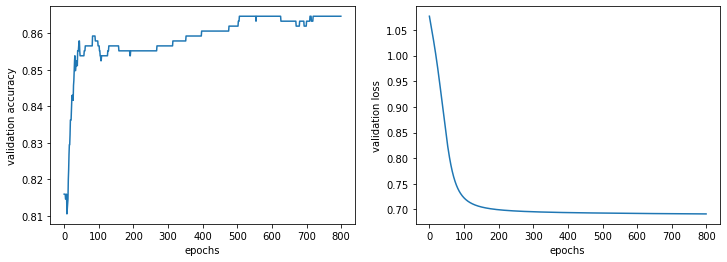

In [218]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax1.set_xlabel("epochs");
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

In [219]:
def predict(f):    
    test = torch.tensor([f], dtype=torch.float32)
    pred = model(test)
    idx = np.argmax(pred.detach().numpy())
    return idx

In [220]:
# idx = id2index["ruthba01"]
# print(players_stats[idx])
# print(normalized[idx])
# print(players_label[idx])

for _, key in enumerate(hof_dict):
    if key not in id2index:
        continue
    idx = id2index[key]
    stats = normalized[idx]
    print(players_dict[key], predict(stats))

Ty Cobb 1
Babe Ruth 1
Honus Wagner 1
Christy Mathewson 0
Walter Johnson 0
Nap Lajoie 1
Tris Speaker 1
Cy Young 0
Rogers Hornsby 1
Mickey Cochrane 0
George Sisler 1
Eddie Collins 1
Jimmy Collins 1
Pete Alexander 0
Lou Gehrig 1
Roger Bresnahan 0
Willie Keeler 1
Cap Anson 1
Buck Ewing 1
Rube Waddell 0
Ed Delahanty 1
Jimmie Foxx 1
Ed Walsh 0
John McGraw 0
Old Hoss Radbourn 0
Pie Traynor 1
King Kelly 1
Herman Long 1
Frankie Frisch 1
Lefty Grove 0
Hughie Jennings 0
Amos Rusie 0
Hal Chase 1
Ross Youngs 0
Fred Clarke 1
Bill Terry 1
Johnny Kling 0
Lou Criger 0
Charlie Comiskey 0
Jerry Denny 0
Bill Lange 0
Wilbert Robinson 0
Harry Stovey 1
George Wright 0
Mordecai Brown 0
Johnny Evers 1
John Clarkson 0
Frank Chance 0
Al Spalding 0
Ray Schalk 0
Al Simmons 1
Ross Barnes 0
Charlie Bennett 0
Hugh Duffy 1
Kid Nichols 0
John Ward 1
Dan Brouthers 1
Fred Dunlap 0
Jack Glasscock 1
Billy Hamilton 1
Ned Williamson 0
Chief Bender 0
Shoeless Joe Jackson 1
Edd Roush 1
Doug Allison 0
Joe Battin 0
Jake Beckley 

In [199]:
y_test[:300]

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])